- 총 2년 동안의 데이터를 활용해 모델 평가.
1. 초반 1년의 데이터 학습 -> 이후 6개월 예측(1년 ~ 1년 6개월) -> 실제 데이터와 비교 평가
2. 1년 6개월 데이터 학습 -> 이후 6개월 예측(1년 6개월 ~ 2년) -> 실제 데이터와 비교 평가

- 선형회귀모델과 비교

In [208]:
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta


import pandas as pd
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# Data Preperation

In [3]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [4]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    # dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


In [ ]:
df =pd.read_excel("data/online_retail_II.xlsx",
                   sheet_name="Year 2010-2011")

In [92]:
df = df_.copy()
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55000,17850.00000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39000,17850.00000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75000,17850.00000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39000,17850.00000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39000,17850.00000,United Kingdom


In [93]:
df = df[~df["Invoice"].str.contains("C", na=False)]   # 주문 취소 데이터 제외
df = df[df["Quantity"] > 0]                           # 수량 0개 or (-)인 데이터 제외 
len(df)

531286

In [94]:
replace_with_thresholds(df, "Quantity")     # 수량 이상치 제거 
replace_with_thresholds(df, "Price")        # 가격 이상치 제거

In [95]:
df.describe([0.05, 0.25, 0.50, 0.75, 0.95, 0.99, 1]).T

,count,mean,std,min,5%,25%,50%,75%,95%,99%,100%,max
Quantity,531286.00000,9.59067,21.67303,1.00000,1.00000,1.00000,3.00000,10.00000,30.00000,100.00000,248.50000,248.50000
Price,531286.00000,3.29045,21.82581,-11062.06000,0.42000,1.25000,2.08000,4.13000,9.95000,16.98000,42.13500,42.13500
Customer ID,397925.00000,15294.30860,1713.17274,12346.00000,12627.00000,13969.00000,15159.00000,16795.00000,17912.00000,18211.00000,18287.00000,18287.00000


In [96]:
df["TotalPrice"] = df["Price"] * df["Quantity"]  # 총 가격 컬럼 생성 

In [97]:
df["InvoiceDate"].min(), df["InvoiceDate"].max()

(Timestamp('2010-12-01 08:26:00'), Timestamp('2011-12-09 12:50:00'))

In [98]:
df = df[df["Country"] == "United Kingdom"]    # 영국 고객 데이터만 분석
df['Country'].unique()

array(['United Kingdom'], dtype=object)

In [108]:
df_6month = df[df['InvoiceDate'] < dt.datetime(2011, 6, 1)]

In [109]:
df_6month

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.00000,2010-12-01 08:26:00,2.55000,17850.00000,United Kingdom,15.30000
1,536365,71053,WHITE METAL LANTERN,6.00000,2010-12-01 08:26:00,3.39000,17850.00000,United Kingdom,20.34000
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.00000,2010-12-01 08:26:00,2.75000,17850.00000,United Kingdom,22.00000
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.00000,2010-12-01 08:26:00,3.39000,17850.00000,United Kingdom,20.34000
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.00000,2010-12-01 08:26:00,3.39000,17850.00000,United Kingdom,20.34000
...,...,...,...,...,...,...,...,...,...
209024,555150,22895,SET OF 2 TEA TOWELS APPLE AND PEARS,3.00000,2011-05-31 15:53:00,3.25000,NaN,United Kingdom,9.75000
209025,555150,22983,CARD BILLBOARD FONT,3.00000,2011-05-31 15:53:00,0.42000,NaN,United Kingdom,1.26000
209026,555150,23169,CLASSIC GLASS COOKIE JAR,3.00000,2011-05-31 15:53:00,4.15000,NaN,United Kingdom,12.45000
209027,555150,23298,SPOTTY BUNTING,5.00000,2011-05-31 15:53:00,4.95000,NaN,United Kingdom,24.75000


In [110]:
# today_date = dt.datetime(2011, 12, 11)
today_date = dt.datetime(2011, 6, 3)

# RFM Table

In [167]:
rfm = df_6month.groupby('Customer ID').agg({'InvoiceDate': [lambda date: (date.max()-date.min()).days,
                                                     lambda date: (today_date-date.min()).days],
                                     'Invoice': lambda num: num.nunique(),
                                     'TotalPrice': lambda price: price.sum()})
rfm.head(2)

InvoiceDate             Invoice TotalPrice
             <lambda_0> <lambda_1> <lambda>   <lambda>
Customer ID                                           
12346.00000           0        135        1  258.44000
12747.00000         170        179        6 2091.40000

In [168]:
rfm.columns = rfm.columns.droplevel(0)

In [169]:
rfm.head(2)

,<lambda_0>,<lambda_1>,<lambda>,<lambda>
Customer ID,,,,
12346.00000,0,135,1,258.44000
12747.00000,170,179,6,2091.40000


In [170]:
rfm.columns = ['recency_cltv_p', 'tenure', 'frequency', 'monetary']

In [171]:
#  통화 평균 계산 
rfm["monetary"] = rfm["monetary"] / rfm["frequency"]
rfm.rename(columns={"monetary": "monetary_avg"}, inplace=True)

In [172]:
# 최근성 및 근속 기간 변수를 주간으로 변환
rfm["recency_weekly_p"] = rfm["recency_cltv_p"] / 7
rfm["tenure_weekly_p"] = rfm["tenure"] / 7

In [173]:
rfm = rfm[rfm["monetary_avg"] > 0]
rfm = rfm[rfm["frequency"] > 1]
rfm["frequency"] = rfm["frequency"].astype(int)

In [174]:
rfm

,recency_cltv_p,tenure,frequency,monetary_avg,recency_weekly_p,tenure_weekly_p
Customer ID,,,,,,
12747.00000,170,179,6,348.56667,24.28571,25.57143
12748.00000,181,183,86,106.89436,25.85714,26.14286
12823.00000,41,106,3,331.50000,5.85714,15.14286
12826.00000,48,175,3,232.36667,6.85714,25.00000
12829.00000,23,170,2,146.50000,3.28571,24.28571
...,...,...,...,...,...,...
18245.00000,143,165,4,326.57250,20.42857,23.57143
18257.00000,89,106,3,240.40000,12.71429,15.14286
18260.00000,152,168,5,443.21400,21.71429,24.00000


# BG/NBD 모델 구축

In [175]:
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(rfm['frequency'],
        rfm['recency_weekly_p'],
        rfm['tenure_weekly_p'])

<lifetimes.BetaGeoFitter: fitted with 1252 subjects, a: 0.25, alpha: 10.84, b: 3.06, r: 2.97>

In [176]:
# 3개월 동안 가장 많이 구매할 것으로 예상되는 10명의 고객(구매횟수)
bgf.conditional_expected_number_of_purchases_up_to_time(3*4,
                                                        rfm['frequency'],
                                                        rfm['recency_weekly_p'],
                                                        rfm['tenure_weekly_p']).sort_values(ascending=False).head(10)

Customer ID
12748.00000   27.68437
13089.00000   16.47640
14606.00000   15.73674
17841.00000   15.49392
15311.00000   14.15373
12971.00000   12.93218
13798.00000   10.77557
16029.00000    9.75969
13694.00000    8.95092
14527.00000    8.94763
dtype: float64

In [178]:
# 3개월 예측 구매 횟수
rfm["exp_sales_3_month"] = bgf.predict(3*4,
                                        rfm['frequency'],
                                        rfm['recency_weekly_p'],
                                        rfm['tenure_weekly_p'])

In [179]:
rfm.sort_values("exp_sales_3_month", ascending=False).head(20)

,recency_cltv_p,tenure,frequency,monetary_avg,recency_weekly_p,tenure_weekly_p,exp_sales_3_month
Customer ID,,,,,,,
12748.00000,181,183,86,106.89436,25.85714,26.14286,27.68437
13089.00000,169,179,51,547.28431,24.14286,25.57143,16.47640
14606.00000,178,183,48,141.28667,25.42857,26.14286,15.73674
17841.00000,180,183,47,245.31106,25.71429,26.14286,15.49392
15311.00000,177,183,43,689.53721,25.28571,26.14286,14.15373
...,...,...,...,...,...,...,...
16333.00000,117,119,16,424.18063,16.71429,17.00000,7.66812
13767.00000,170,183,22,329.14955,24.28571,26.14286,7.52967
13468.00000,171,183,21,171.00571,24.42857,26.14286,7.25415


In [180]:
rfm.exp_sales_3_month.sum()

2920.7394303906794

In [181]:
# 3개월 동안 회사 전체의 예상 구매 횟수
bgf.predict(4*3,
            rfm['frequency'],
            rfm['recency_weekly_p'],
            rfm['tenure_weekly_p']).sum()

2920.7394303906794

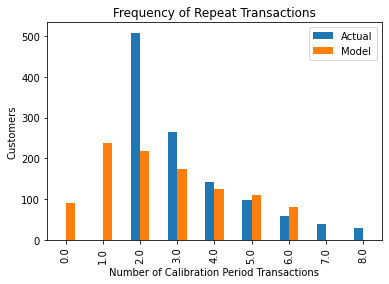

In [182]:
# 예측 결과 평가
plot_period_transactions(bgf)
plt.show()

# GAMMA-GAMMA 모델 구축
- It is used to estimate the average monetary value of customer transactions.

In [184]:
ggf = GammaGammaFitter(penalizer_coef=0.01)  
ggf.fit(rfm['frequency'], rfm['monetary_avg'])

<lifetimes.GammaGammaFitter: fitted with 1252 subjects, p: 3.82, q: 0.35, v: 3.75>

In [185]:
rfm.head(2)

,recency_cltv_p,tenure,frequency,monetary_avg,recency_weekly_p,tenure_weekly_p,exp_sales_3_month
Customer ID,,,,,,,
12747.00000,170,179,6,348.56667,24.28571,25.57143,2.72920
12748.00000,181,183,86,106.89436,25.85714,26.14286,27.68437


In [194]:
rfm.sort_values('monetary_avg', ascending=False).head(20)

,recency_cltv_p,tenure,frequency,monetary_avg,recency_weekly_p,tenure_weekly_p,exp_sales_3_month
Customer ID,,,,,,,
18102.00000,160,177,15,3088.61100,22.85714,25.28571,5.47086
15749.00000,97,142,3,2521.44667,13.85714,20.28571,1.84161
12939.00000,61,144,3,2375.96500,8.71429,20.57143,1.19255
17511.00000,167,183,15,2367.25933,23.85714,26.14286,5.37392
17450.00000,175,177,14,2273.48214,25.00000,25.28571,5.33352
...,...,...,...,...,...,...,...
15769.00000,173,181,13,1490.12269,24.71429,25.85714,4.89730
14769.00000,156,167,4,1459.33750,22.28571,23.85714,2.19104
17340.00000,173,176,4,1450.70250,24.71429,25.14286,2.13986


In [187]:
rfm.monetary_avg.describe([0, .25, .5, .75, .8, .85, .9, .95])

count   1252.00000
mean     350.07700
std      280.78148
min       10.65500
0%        10.65500
           ...    
80%      464.52238
85%      522.10550
90%      596.19204
95%      825.21121
max     3088.61100
Name: monetary_avg, Length: 13, dtype: float64

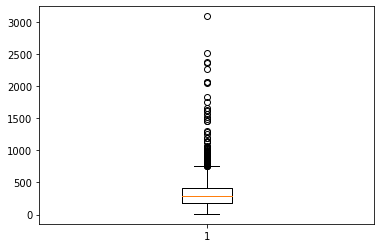

In [189]:
import matplotlib.pyplot as plt
plt.boxplot(rfm.monetary_avg);

In [164]:
# conditional_expected_average_profit : 평균이익의 조건부 기대값을 계산
# 고객의 기대 구입액 계산
ggf.conditional_expected_average_profit(rfm['frequency'],
                                        rfm['monetary_avg']).sort_values(ascending=False).head(10)

Customer ID
18102.00000   3124.47245
15749.00000   2675.14762
12939.00000   2520.87416
17511.00000   2394.80426
17450.00000   2301.85954
17107.00000   2253.95150
15251.00000   2241.32736
13081.00000   2118.49202
15125.00000   1910.26359
16684.00000   1783.89693
dtype: float64

In [224]:
rfm["expected_average_profit"] = ggf.conditional_expected_average_profit(rfm['frequency'],
                                                                         rfm['monetary_avg'])

In [225]:
rfm.sort_values("expected_average_profit", ascending=False)

,recency_cltv_p,tenure,frequency,monetary_avg,recency_weekly_p,tenure_weekly_p,exp_sales_3_month,expected_average_profit
Customer ID,,,,,,,,
18102.00000,160,177,15,3088.61100,22.85714,25.28571,5.47086,3124.47245
15749.00000,97,142,3,2521.44667,13.85714,20.28571,1.84161,2675.14762
12939.00000,61,144,3,2375.96500,8.71429,20.57143,1.19255,2520.87416
17511.00000,167,183,15,2367.25933,23.85714,26.14286,5.37392,2394.80426
17450.00000,175,177,14,2273.48214,25.00000,25.28571,5.33352,2301.85954
...,...,...,...,...,...,...,...,...
17961.00000,175,182,20,39.57625,25.00000,26.00000,7.06173,40.10638
13666.00000,0,97,2,32.02500,0.00000,13.85714,0.49022,37.06649
12970.00000,0,132,2,11.90000,0.00000,18.85714,0.18865,15.06035


# BG-NBD 및 GG 모델을 사용한 CLTV 계산.

In [195]:
pre_cltv = ggf.customer_lifetime_value(bgf,
                                   rfm['frequency'],
                                   rfm['recency_weekly_p'],
                                   rfm['tenure_weekly_p'],
                                   rfm['monetary_avg'],
                                   time=3,   # 6개월
                                   freq="W",
                                   discount_rate=0.01)

In [196]:
pre_cltv.head()

Customer ID
12747.00000   1041.66009
12748.00000   3150.50282
12823.00000    580.73791
12826.00000    117.30980
12829.00000     42.20822
Name: clv, dtype: float64

In [197]:
pre_cltv.shape

(1252,)

In [198]:
pre_cltv = pre_cltv.reset_index()

In [199]:
pre_cltv.sort_values(by="clv", ascending=False).head(50)

,Customer ID,clv
1215,18102.00000,18152.33062
1066,17511.00000,13667.31932
1055,17450.00000,13037.39311
569,15311.00000,10407.74433
202,13694.00000,10125.59087
...,...,...
680,15856.00000,3181.00009
1,12748.00000,3150.50282
760,16210.00000,3135.07764
1108,17675.00000,3091.71542


In [212]:
rfm_cltv_final = rfm.merge(pre_cltv, on="Customer ID", how="left")
rfm_cltv_final.sort_values(by="clv", ascending=False).head()
rfm_cltv_final.rename(columns={"clv": "exp_cltv"}, inplace=True)
rfm_cltv_final.head(2)

,Customer ID,recency_cltv_p,tenure,frequency,monetary_avg,recency_weekly_p,tenure_weekly_p,exp_sales_3_month,exp_cltv
0,12747.00000,170,179,6,348.56667,24.28571,25.57143,2.72920,1041.66009
1,12748.00000,181,183,86,106.89436,25.85714,26.14286,27.68437,3150.50282


In [214]:
predict_df = rfm_cltv_final[['Customer ID', 'exp_sales_3_month', 'exp_cltv' ]]
predict_df.rename(columns={"exp_sales_3_month": "exp_freq"}, inplace=True)
predict_df.head(2)

,Customer ID,exp_freq,exp_cltv
0,12747.00000,2.72920,1041.66009
1,12748.00000,27.68437,3150.50282


In [203]:
real_df = df[(df['InvoiceDate'] >= dt.datetime(2011, 6, 1)) & (df['InvoiceDate'] < dt.datetime(2011, 9, 1)) ]
real_df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
209029,555156,23299,FOOD COVER WITH BEADS SET 2,6.00000,2011-06-01 07:37:00,3.75000,15643.00000,United Kingdom,22.50000
209030,555156,22847,BREAD BIN DINER STYLE IVORY,1.00000,2011-06-01 07:37:00,16.95000,15643.00000,United Kingdom,16.95000
209031,555157,23075,PARLOUR CERAMIC WALL HOOK,16.00000,2011-06-01 07:38:00,4.15000,15643.00000,United Kingdom,66.40000
209032,555157,47590B,PINK HAPPY BIRTHDAY BUNTING,6.00000,2011-06-01 07:38:00,5.45000,15643.00000,United Kingdom,32.70000
209033,555157,22423,REGENCY CAKESTAND 3 TIER,4.00000,2011-06-01 07:38:00,12.75000,15643.00000,United Kingdom,51.00000
...,...,...,...,...,...,...,...,...,...
320690,565067,22637,PIGGY BANK RETROSPOT,2.00000,2011-08-31 17:16:00,2.55000,15856.00000,United Kingdom,5.10000
320691,565067,22646,CERAMIC STRAWBERRY CAKE MONEY BANK,2.00000,2011-08-31 17:16:00,1.45000,15856.00000,United Kingdom,2.90000
320692,565067,22741,FUNKY DIVA PEN,48.00000,2011-08-31 17:16:00,0.85000,15856.00000,United Kingdom,40.80000
320694,565070,85032D,NaN,171.00000,2011-08-31 17:18:00,0.00000,NaN,United Kingdom,0.00000


In [228]:
rfm_value = real_df.groupby('Customer ID').agg({'Invoice': lambda num: num.nunique(),
                                     'TotalPrice': lambda price: price.sum()})
rfm_value.rename(columns={"Invoice": "real_freq", "TotalPrice" : "real_monetary"}, inplace=True)
rfm_value.reset_index(level=0, inplace=True)
rfm_value.head(2)

,Customer ID,real_freq,real_monetary
0,12747.00000,2,678.00000
1,12748.00000,41,4017.77000


In [235]:
len(predict_df), len(rfm_value)

(1252, 1743)

In [243]:
result = pd.merge(predict_df, rfm_value, how='left', on='Customer ID')
result

,Customer ID,exp_freq,exp_cltv,real_freq,real_monetary
0,12747.00000,2.72920,1041.66009,2.00000,678.00000
1,12748.00000,27.68437,3150.50282,41.00000,4017.77000
2,12823.00000,1.55136,580.73791,1.00000,229.50000
3,12826.00000,0.44599,117.30980,1.00000,121.52000
4,12829.00000,0.24505,42.20822,NaN,NaN
...,...,...,...,...,...
1247,18245.00000,2.16114,785.01085,2.00000,366.52000
1248,18257.00000,2.40340,653.37234,2.00000,841.67000
1249,18260.00000,2.48730,1213.96541,1.00000,427.13000
1250,18272.00000,2.29953,1311.47901,2.00000,1125.91000


In [244]:
result.isna().sum()

Customer ID        0
exp_freq           0
exp_cltv           0
real_freq        407
real_monetary    407
dtype: int64

In [246]:
result.fillna(0, inplace=True)
result.isna().sum()

Customer ID      0
exp_freq         0
exp_cltv         0
real_freq        0
real_monetary    0
dtype: int64

In [247]:
from sklearn import metrics
import math

In [255]:
# RMSE
metrics.mean_squared_error(result['real_freq'], result['exp_freq'])**0.5

1.8699457201161431

In [257]:
# RMSE
metrics.mean_squared_error(result['real_monetary'], result['exp_cltv'])**0.5

1690.6524071148044

In [259]:
result['gap_freq'] = result['exp_freq'] - result['real_freq']
result['gap_cltv'] = result['exp_cltv'] - result['real_monetary']
result.head(5)

,Customer ID,exp_freq,exp_cltv,real_freq,real_monetary,gap_freq,gap_cltv
0,12747.00000,2.72920,1041.66009,2.00000,678.00000,0.72920,363.66009
1,12748.00000,27.68437,3150.50282,41.00000,4017.77000,-13.31563,-867.26718
2,12823.00000,1.55136,580.73791,1.00000,229.50000,0.55136,351.23791
3,12826.00000,0.44599,117.30980,1.00000,121.52000,-0.55401,-4.21020
4,12829.00000,0.24505,42.20822,0.00000,0.00000,0.24505,42.20822


In [262]:
result.gap_cltv.mean()

188.25405438392238

- 예측은 됐지만 실제로 사지 않은 사람의 수
- 9개월 훈련 - 3개월 예측, 1개월 예측